In [1]:
# Initial imports
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

%matplotlib inline

In [2]:
# Load the data
df = pd.read_csv(
    Path("../Resources/final_data_frame.csv"),
    infer_datetime_format=True,
    parse_dates=True,
)
df.rename(columns = {'Unnamed: 0': 'date' }, 
                 inplace = True
                )

df.set_index('date', inplace = True)
df.head(5)

,TSLA,QQQ,Y_d1_pr_change_diff,Y_d5_pr_change_diff,quarterly report announcement flag,tweet count,number likes,number replies,number retweets clean,compound,...,mars,time,rocket,engine,soon,tesla,spacex,keyword strength,keyword flag,tweet flag
date,,,,,,,,,,,,,,,,,,,,,
2010-06-29,4.778,39.031284,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-06-30,4.766,38.437302,0.012707,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-07-01,4.392,38.329292,-0.075662,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-07-02,3.840,38.221321,-0.122866,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-07-06,3.222,38.338306,-0.163998,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [4]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 5

feature_column = 0
target_column = 0
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[4.77799988 4.76599979 4.3920002  3.83999991 3.22199988]
 [4.76599979 4.3920002  3.83999991 3.22199988 3.16000009]
 [4.3920002  3.83999991 3.22199988 3.16000009 3.4920001 ]
 [3.83999991 3.22199988 3.16000009 3.4920001  3.48000002]
 [3.22199988 3.16000009 3.4920001  3.48000002 3.41000009]] 

y sample values:
[[3.16000009]
 [3.4920001 ]
 [3.48000002]
 [3.41000009]
 [3.62800002]]


### Splitting Data Between Training and Testing Sets

To avoid the dataset being randomized, we will manually split the data using array slicing.

In [5]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

### Scaling Data with `MinMaxScaler`

In [6]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that we need to reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`.

Both sets, training, and testing are reshaped.

In [7]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[1.84522017e-03]
  [1.83153488e-03]
  [1.40501344e-03]
  [7.75494165e-04]
  [7.07066082e-05]]

 [[1.83153488e-03]
  [1.40501344e-03]
  [7.75494165e-04]
  [7.07066082e-05]
  [0.00000000e+00]]

 [[1.40501344e-03]
  [7.75494165e-04]
  [7.07066082e-05]
  [0.00000000e+00]
  [3.78623737e-04]]

 [[7.75494165e-04]
  [7.07066082e-05]
  [0.00000000e+00]
  [3.78623737e-04]
  [3.64938446e-04]]

 [[7.07066082e-05]
  [0.00000000e+00]
  [3.78623737e-04]
  [3.64938446e-04]
  [2.85108221e-04]]] 

X_test sample values:
[[[0.06550418]
  [0.06833474]
  [0.06680656]
  [0.06739958]
  [0.06767329]]

 [[0.06833474]
  [0.06680656]
  [0.06739958]
  [0.06767329]
  [0.06825491]]

 [[0.06680656]
  [0.06739958]
  [0.06767329]
  [0.06825491]
  [0.06681568]]

 [[0.06739958]
  [0.06767329]
  [0.06825491]
  [0.06681568]
  [0.06888443]]

 [[0.06767329]
  [0.06825491]
  [0.06681568]
  [0.06888443]
  [0.0676961 ]]]


---

## Build and Train the LSTM RNN

We will need to:

1. Define the model architecture in Keras.
2. Compile the model.
3. Fit the model to the training data.

### Importing the Keras Modules

* `Dropout`: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [8]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Defining the LSTM RNN Model Structure

To create an LSTM RNN model, we will add `LSTM` layers. The `return_sequences` parameter needs to set to `True` every time we add a new `LSTM` layer, excluding the final layer. The `input_shape` is the number of time steps and the number of indicators

After each `LSTM` layer, we add a `Dropout` layer to prevent overfitting. The parameter passed to the `Dropout` layer is the fraction of nodes that will be drop on each epoch.
* Ex. a dropout value of `0.2` will randomly drop `20%` of the units on each epoch.

The number of units in each `LSTM` layers, is equal to the size of the time window. 
* Ex. if we are taking five previous `TSLA` closing price to predict the next closing price, number of units is 5 in each layer.

In [9]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

### Compiling the LSTM RNN Model

We will compile the model, using the `adam` optimizer, as loss function, we will use `mean_square_error` since the value we want to predict is continuous.

In [10]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [11]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 5)              140       
_________________________________________________________________
dropout (Dropout)            (None, 5, 5)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 5)              220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

### Training the Model

Once the model is defined, we train (fit) the model using `10` epochs. Since we are working with time-series data, it's important to set `shuffle=False` since it's necessary to keep the sequential order of the data.

We can experiment with the `batch_size` parameter; however, smaller batch size is recommended.

In [12]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
1857/1857 [==============================] - 11s 4ms/step - loss: 3.1492e-06
Epoch 2/10
1857/1857 [==============================] - 6s 3ms/step - loss: 9.1376e-05
Epoch 3/10
1857/1857 [==============================] - 8s 4ms/step - loss: 9.7809e-05
Epoch 4/10
1857/1857 [==============================] - 8s 4ms/step - loss: 9.8329e-05
Epoch 5/10
1857/1857 [==============================] - 7s 4ms/step - loss: 1.0184e-04
Epoch 6/10
1857/1857 [==============================] - 7s 4ms/step - loss: 1.0066e-04
Epoch 7/10
1857/1857 [==============================] - 7s 4ms/step - loss: 1.0195e-04
Epoch 8/10
1857/1857 [==============================] - 7s 4ms/step - loss: 1.0179e-04
Epoch 9/10
1857/1857 [==============================] - 7s 4ms/step - loss: 1.0094e-04
Epoch 10/10
1857/1857 [==============================] - 7s 4ms/step - loss: 1.0215e-04


---
## Model Performance

In this section, we will evaluate the model using the test data. 

We will need to:

1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the `X_test` data to make predictions.
3. Create a DataFrame of real (`y_test`) vs predicted values.
4. Plot the Real vs predicted values as a line chart.

### Evaluate the Model

In [13]:
# Evaluate the model
model.evaluate(X_test, y_test)

25/25 [==============================] - 1s 2ms/step - loss: 0.0449 


0.04490906372666359

### Making Predictions

In [14]:
# Make some predictions
predicted = model.predict(X_test)

Since we scaled the original values using the `MinMaxScaler`, we need to recover the original prices to better understand the predictions.

The `inverse_transform()` method of the scaler to decode the scaled values to their original scale.

In [15]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

### Plotting Predicted Vs. Real Prices

To plot the predicted vs. the real values, we will create a DataFrame.

In [16]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
date,,
2017-11-17,63.009998,60.016552
2017-11-20,61.748001,60.016552
2017-11-21,63.562000,60.016552
2017-11-22,62.520000,60.016552
2017-11-24,63.110001,60.016552


<AxesSubplot:xlabel='date'>

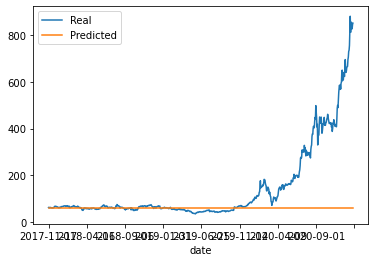

In [17]:
# Plot the real vs predicted prices as a line chart
stocks.plot()

# CAN BE DELETED

In [18]:
# # Use 70% of the data for training and the remainder for testing
# split = int(0.7 * len(X))
# X_train = X[: split]
# X_test = X[split:]
# y_train = y[: split]
# y_test = y[split:]

# # Generate 1000 demo data samples with 2 features and two centers
# X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=78)

# # Transforming y to a vertical vector
# y = y.reshape(-1, 1)
# y.shape

# # Creating a DataFrame with the dummy data
# df = pd.DataFrame(X, 
#                   columns=["Feature 1", "Feature 2"]
#                  )
# df["Target"] = y
# df.head()

# # Plotting the dummy data
# df.plot.scatter(x="Feature 1", y="Feature 2", c="Target", colormap="winter")

# # Create training and testing datasets
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# # Create scaler instance
# X_scaler = StandardScaler()

# # Fit the scaler
# X_scaler.fit(X_train)

# # Scale the data
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

# # Create a sequential model
# neuron = Sequential()

# # First layer
# number_inputs = 2
# number_hidden_nodes = 1

# neuron.add(Dense(units=number_hidden_nodes, 
#                  activation="relu", 
#                  input_dim=number_inputs)
#           )

# # Output layer
# number_classes = 1

# neuron.add(Dense(units=number_classes, activation="sigmoid"))

# # Model summary
# neuron.summary()

# # Compile model
# neuron.compile(loss="binary_crossentropy", 
#                optimizer="adam", 
#                metrics=["accuracy"]
#               )

# # Fitting the model with linear dummy data
# model = neuron.fit(X_train_scaled, 
#                    y_train, 
#                    epochs=100
#                   )

# # Create a DataFrame with the history dictionary
# df = pd.DataFrame(model.history, 
#                   index = range(1, len(model.history["loss"]) + 1)
#                  )

# # Plot the loss
# df.plot(y = "loss")

# # Plot the accuracy
# df.plot(y = "accuracy")

# # Evaluate the model fit with linear dummy data
# model_loss, model_accuracy = neuron.evaluate(X_test_scaled, 
#                                              y_test, 
#                                              verbose=2
#                                             )

# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


# # Create 10 new samples of dummy data
# new_X, new_y = make_blobs(n_samples=10, 
#                           centers=2, 
#                           n_features=2, 
#                           random_state=78
#                          )


# # Making predictions
# predictions = neuron.predict_classes(new_X)
# results = pd.DataFrame({"predictions": predictions.ravel(), 
#                         "actual": new_y}
#                       )
# results.head(10)


# # Creating dummy non-linear data
# X_moons, y_moons = make_moons(n_samples=1000, 
#                               noise=0.08, 
#                               random_state=78
#                              )


# # Transforming y_moons to a vertical vector
# y_moons = y_moons.reshape(-1, 1)


# # Creating a DataFrame to plot the non-linear dummy data
# df_moons = pd.DataFrame(X_moons, 
#                         columns=["Feature 1", "Feature 2"]
#                        )
# df_moons["Target"] = y_moons
# df_moons.head()


# # Plotting the non-linear dummy data
# df_moons.plot.scatter(x="Feature 1", 
#                       y="Feature 2", 
#                       c="Target", 
#                       colormap="winter"
#                      )

# # Create training and testing sets
# X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(
#     X_moons, 
#     y_moons, 
#     random_state=78
# )

# # Create the scaler instance
# X_moon_scaler = StandardScaler()

# # Fit the scaler
# X_moon_scaler.fit(X_moon_train)

# # Scale the data
# X_moon_train_scaled = X_moon_scaler.transform(X_moon_train)
# X_moon_test_scaled = X_moon_scaler.transform(X_moon_test)


# # Training the model with the non-linear data
# model_moon = neuron.fit(X_moon_train_scaled, 
#                         y_moon_train, 
#                         epochs=100
#                        )


# # Create a DataFrame with the history dictionary
# df_moon = pd.DataFrame(
#     model_moon.history, 
#     index=range(1, len(model_moon.history["loss"]) + 1)
# )

# # Plot the loss
# df_moon.plot(y="loss")

# # Plot the accuracy
# df_moon.plot(y="accuracy")

# # Evaluate the model using non-linear data
# model_moon_loss, model_moon_accuracy = neuron.evaluate(
#     X_moon_test_scaled, 
#     y_moon_test, 
#     verbose=2
# )

# print(f"Loss: {model_moon_loss}, Accuracy: {model_moon_accuracy}")


# # Create demo data
# X_new_moons, y_new_moons = make_moons(n_samples=10, 
#                                       noise=0.08, 
#                                       random_state=78
#                                      )


# # Making predictions
# predictions_moon = neuron.predict_classes(X_new_moons)
# results = pd.DataFrame({"predictions": predictions_moon.ravel(), 
#                         "actual": y_new_moons}
#                       )
# results.head(10)
